# Estimating Home Prices


Estimating home values is an important aspect of the Windfall net worth model.  Property often represents a significant portion of an individual’s net worth and, due to changing home values, can be a significant driver of wealth growth. 

Your task is to create a model using the attached dataset to attempt to predict home values in Denver.

The dataset contains information on approximately 3,000 single-family homes in Denver, CO.  Each row contains the following information about the property that can be used to estimate the home’s value:
- Address
- Square footage (ft^2)
- Lot size (ft^2)
- Number of bedrooms
- Number of bathrooms
- The year the house was built
- The year the house was last sold
- The amount the house was last sold for

In addition, we have included the Zillow “Zestimate” (http://www.zillow.com/zestimate) of each home’s current value in the `estimated_value` column of the attached file.  You should use these estimates to train your model.

We have reserved a set of single family home records from Denver that we will use to assess the quality of your model.  The reserve dataset is in the same format as the training set.

Please implement a model using either python or R.  When you are finished, send us back:

1. Your code
2. Instructions for running your model on our reserve dataset
3. A short explanation of how you arrived at your answer (see below)

Here are some points you may want to cover when writing your explanation:
* What was your methodology in assessing the data?
* How did you decide which features were important and which ones were of no value?
* Did you consider any strategies other than the one you used for your final model?  What were they?
* How did you train your model?
* How did you evaluate the accuracy of your model?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
csv = pd.read_csv("single_family_home_values.csv", parse_dates=["last_sale_date"])

In [3]:
print csv.shape
csv.head()

(3417, 14)


,address,city,state,zipcode,property_type,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value
0,2495 S Milwaukee St,Denver,CO,80210,Single Family Residence,3885,7500,13,4,5,2010,350000,2010-06-07,1684147
1,2690 Niagara St,Denver,CO,80207,Single Family Residence,1343,7500,6,3,1,1948,31500,1978-02-01,343104
2,3425 Grove St,Denver,CO,80211,Single Family Residence,992,6250,5,2,2,1921,258000,2002-02-19,510436
3,4794 Claude Ct,Denver,CO,80216,Single Family Residence,491,2990,3,1,1,1891,0,2011-04-27,184105
4,3640 N Gaylord St,Denver,CO,80205,Single Family Residence,1365,4690,6,3,1,1912,52600,1980-09-01,390055


In [4]:
#scale the data
from sklearn import preprocessing
from scipy import stats

## Data Preprocessing


### Impune Missing Values

Typically missing values in datasets are blank but in this dataset they are filled w `0` values. We can either drop these rows/examples or fill them w/ some averaging technique.

In [5]:
# fill missing values (0's) w/ the median for the column
cols = ["square_footage", "lot_size", "num_rooms", "num_bedrooms", "num_baths", "year_built", 
     "last_sale_amount", "estimated_value"]

for col in cols:
    csv.loc[csv[col]==0, col] = csv[col].median()

In [6]:
csv.head(4)

,address,city,state,zipcode,property_type,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value
0,2495 S Milwaukee St,Denver,CO,80210,Single Family Residence,3885,7500,13,4,5,2010,350000,2010-06-07,1684147
1,2690 Niagara St,Denver,CO,80207,Single Family Residence,1343,7500,6,3,1,1948,31500,1978-02-01,343104
2,3425 Grove St,Denver,CO,80211,Single Family Residence,992,6250,5,2,2,1921,258000,2002-02-19,510436
3,4794 Claude Ct,Denver,CO,80216,Single Family Residence,491,2990,3,1,1,1891,194900,2011-04-27,184105


### Location/Address Information

Although location is obviously a VERY important characteristic of home value, we CANNOT use it in its current form in this model. 

If we use zip code, an ordinal value, we would have to one-hot encode it, which would add about 30 dimensions, which due to the relatively small size of the training set would add a large factor of bias to the model and would other words drastically overfit. 

A more optimal solution, outside of the scope if this exercise would be to reverse geocode the address to lat/lng paris. If I can convert address to lat/lng it could be considered a continuous feature and only add 2 dimensions and get a lot of added value.

For now we have to ignore location information.

P.S.

One of my favorite uses of zip code data is to look up demographic variables based on zipcode that may not be available at the individual level otherwise...


### Property Type

This feature is useless, removing it...

In [154]:
model_cols = ["square_footage", "lot_size", "num_rooms", "num_bedrooms", "num_baths", "year_built", 
              "last_sale_amount", "last_sale_date", "estimated_value"]
housing=csv[model_cols]
housing.head()

,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value
0,3885,7500,13,4,5,2010,350000,2010-06-07,1684147
1,1343,7500,6,3,1,1948,31500,1978-02-01,343104
2,992,6250,5,2,2,1921,258000,2002-02-19,510436
3,491,2990,3,1,1,1891,194900,2011-04-27,184105
4,1365,4690,6,3,1,1912,52600,1980-09-01,390055


## Transform Dates

The categorical feature `last_sale_date` needs to be converted into a continuous form: we will represent the Date objects as integers representing days since the epoch. We will define the epoch as 1/1/1900

In [155]:
housing["day"] = (housing.last_sale_date - pd.datetime(1900,1,1))/np.timedelta64(1,'D')
housing.drop("last_sale_date", 1, inplace=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [156]:
housing.head(5) 

,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,estimated_value,day
0,3885,7500,13,4,5,2010,350000,1684147,40334
1,1343,7500,6,3,1,1948,31500,343104,28520
2,992,6250,5,2,2,1921,258000,510436,37304
3,491,2990,3,1,1,1891,194900,184105,40658
4,1365,4690,6,3,1,1912,52600,390055,29463


### Number of rooms

The column num_rooms is the total number of rooms in the property including bedrooms and baths, so there is some overlap between this and the `num_bedrooms` and `num_baths` columns. We can subtract the sum of num_bedrooms and num_baths from num_rooms to increase the variance in the column. SO this column will essentially be transformed to `other_room_count`

**Note**

*I think I don't understand this column, b/c example id 3393 (see below) has less total rooms than bedrooms+bathrooms. I'm just going to skip this optimization for now.*

In [163]:
housing.iloc[3393]

square_footage        1230
lot_size              6250
num_rooms                5
num_bedrooms             3
num_baths                3
year_built            1973
last_sale_amount    335000
estimated_value     467100
day                  41938
Name: 3393, dtype: float64

## Outliers

In [10]:
# outlier_check_cols = ["square_footage", "lot_size", "num_rooms", "num_bedrooms", "num_baths", "year_built", 
#      "last_sale_amount", "estimated_value", "day"]

# for col in outlier_check_cols:
#     housing[col] = np.abs(stats.zscore(housing[col])) < 3 

housing_sans_outliers = housing[(np.abs(stats.zscore(housing)) < 3).all(axis=1)]
print housing.shape
print housing[(np.abs(stats.zscore(housing)) < 3).all(axis=1)].shape

(3417, 9)
(3265, 9)


In [11]:
housing_sans_outliers.head(5)

,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,estimated_value,day
1,1343,7500,6,3,1,1948,31500,343104,28520
2,992,6250,5,2,2,1921,258000,510436,37304
3,491,2990,3,1,1,1891,194900,184105,40658
4,1365,4690,6,3,1,1912,52600,390055,29463
5,1112,5190,5,2,2,1925,15000,433793,29066


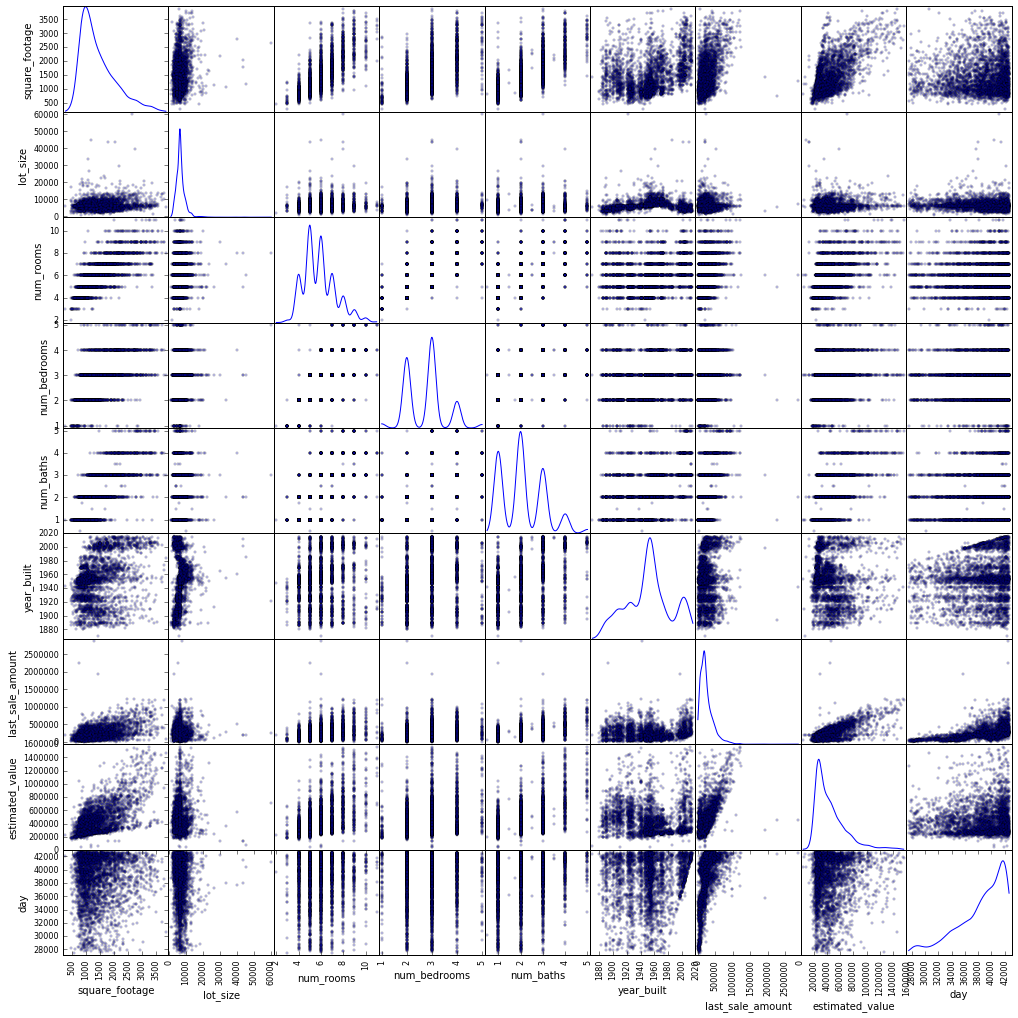

In [12]:
#check correlations

from pandas.tools.plotting import scatter_matrix
_=scatter_matrix(housing_sans_outliers, alpha=0.2, figsize=(17, 17), diagonal='kde')

## Skewedness

loss minimizers/optimizers usually perform better when the variables have means and std deviations that are not too far apart. Doing log() or sqrt() usually helps reduce the scale of the variables so that they are closer to each other.

I log transformed certain features for which the skew was > 0.75. This will make the feature more normally distributed and this makes linear regression perform better - since linear regression is sensitive to outliers. Note that if I used a tree-based model I wouldn't need to transform the variables.

In [13]:
#log transform skewed numeric features:
numeric_feats = housing_sans_outliers.dtypes[housing_sans_outliers.dtypes != "object"].index

skewed_feats = housing_sans_outliers[numeric_feats].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

print skewed_feats

housing_sans_outliers[skewed_feats] = np.log1p(housing_sans_outliers[skewed_feats])

Index([u'square_footage', u'lot_size', u'last_sale_amount',
       u'estimated_value'],
      dtype='object')


/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [14]:
housing_sans_outliers.head()

,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,estimated_value,day
1,7.203406,8.922792,6,3,1,1948,10.357775,12.745792,28520
2,6.900731,8.740497,5,2,2,1921,12.460719,13.143023,37304
3,6.198479,8.003363,3,1,1,1891,12.180247,12.123267,40658
4,7.219642,8.453401,6,3,1,1912,10.870490,12.874046,29463
5,7.014814,8.554682,5,2,2,1925,9.615872,12.980325,29066


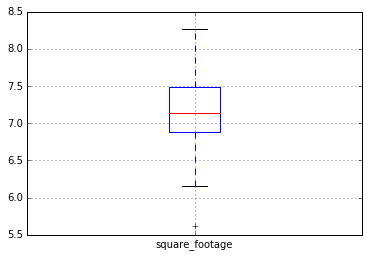

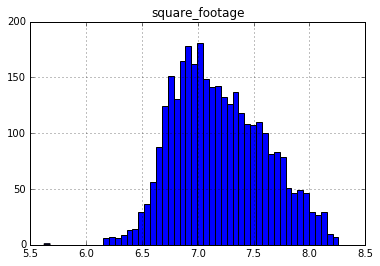

In [15]:
# scaled_sq_footage = preprocessing.scale(csv[["square_footage"]])
_ = housing_sans_outliers[["square_footage"]].boxplot(return_type='dict')
_ = housing_sans_outliers[["square_footage"]].hist(bins=50)

## Scaling

For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

We know that scaling is beneficial for linear models. We already sclaed in essence in the previous skew correction step, however, it didn't run for every feature, so we'll just do it here for all features for good measure.

In [105]:
final = housing_sans_outliers[["square_footage", "lot_size", "num_rooms", "num_bedrooms", "num_baths", "year_built", 
         "last_sale_amount", "day", "estimated_value"]]

# through experimentation scaling doesn't help much
# scaled = preprocessing.scale(final.values)
scaled = final.values 
features = scaled[:,0:-1]
labels = scaled[:,-1]

## Training

First, let's try Regression w/ Lasso Regulation and then Regression. Then we will try a more sophisticated model: Gradient Boosting and then explore blending the models together.

Let's create a training and test set

In [106]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import r2_score

In [107]:
#test train split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.25, random_state=4)

### Lasso

In [111]:
lassocv = linear_model.LassoCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75])
lassocv.fit(features, labels)
lassocv.alpha_  

0.050000000000000003

In [190]:
lasso = linear_model.Lasso(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
lasso.score(X_test, Y_test)

0.57609395122369689

As you can see from the above output, Lasso scores an R^2 of .576. Let's check out what features it found important and then compare w/ Ridge:

Lasso picked 5 variables and eliminated the other 3 variables


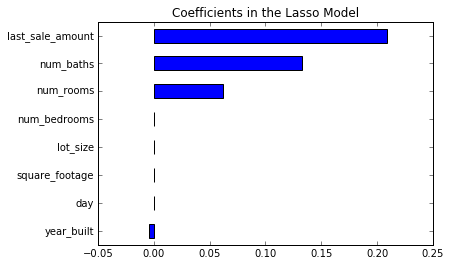

In [113]:
training_cols = ["square_footage", "lot_size", "num_rooms", "num_bedrooms", "num_baths", "year_built", 
      "last_sale_amount", "day"]
coef = pd.Series(lasso.coef_, index = training_cols)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()

imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Some of these make sense: Last Sale, Num Baths, Num Rooms are intuitively related to home price prediction. However, it is a bit incomprehensible that it decided to disgard lot size as having no importance. This can be seen as a limitation of the Lasso Regularization, let's see if Ridge can overcome this:

### Ridge

In [108]:
regcv = linear_model.RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75])
regcv.fit(features, labels)
regcv.alpha_  

1.0

In [191]:
reg = linear_model.Ridge(alpha=regcv.alpha_)
reg.fit(X_train, Y_train)
ridge_preds = reg.predict(X_test)
reg.score(X_test, Y_test)

0.66273997829631215

Nice! We have a marked improvement over Lasso!

### Gradient Boosting

In [250]:
parameters = {'n_estimators':[100,300,500],'max_depth':[2, 5, 10], 'min_samples_split': [2,4,8], 
              'learning_rate': [0.1, .5]}
gbr = ensemble.GradientBoostingRegressor()
gscv = GridSearchCV(gbr, parameters)
gscv.fit(features, labels)
                            

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_learning_rate',
 'param_max_depth',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [251]:
gscv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [252]:
params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
gbr = gscv.best_estimator_
gbr.fit(X_train, Y_train)
gbr.score(X_test, Y_test)

0.77661911073216805

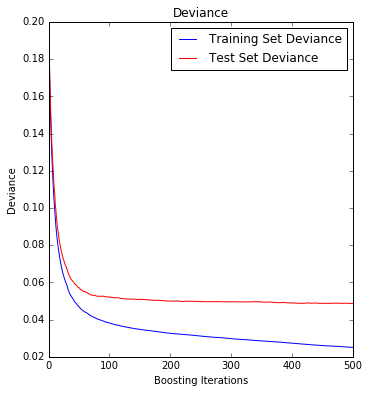

In [242]:
0.76074209487440014

In [115]:
gb_preds = gbr.predict(X_test)

## Blended Model

If you have multiple models that you blend together to reduce variance and make your predictions more stable. We will do a simple linear combination of the base predictors: Ridge and GB

And there you have it, our blended model performs better (76.63%) than its parts (76.22% & 57.60%)

Now let's formalize the blended model w/ mlxtend and run Evaluation tests:

In [200]:
from mlxtend.regressor import StackingRegressor

In [253]:
meta = linear_model.LinearRegression()
blender = StackingRegressor(regressors=[reg, gbr], meta_regressor=meta)
_=blender.fit(X_train, Y_train)
y_pred = blender.predict(X_test)
blender.score(X_test, Y_test)

0.76826629438944538

# Evaluation

10-Fold Cross Validation to evaluate the average score of out model across 10 random samples from out dataset.

In [228]:
from sklearn.model_selection import cross_val_score

In [254]:
scores = cross_val_score(blender, features, labels, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.04)


As you can see the R^2 is .78 which is very respectful. 

Lets take the average diff between actual and predicted: On this training set it is about 18% error which is very respectful.

In [255]:
mean_diff = np.mean(np.abs(np.exp(Y_test)-np.exp(y_pred)))
p_mean_diff = np.mean(mean_diff/np.exp(Y_test))
print "Mean Error:\t %.0f/%0.3f%%" % (mean_diff, p_mean_diff*100)

Mean Error:	 62694/17.428%
